In [2]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

### Model Comparison and Selection

We trained and compared multiple regression models to predict national-level **CO₂ savings** based on EV adoption rate and grid emission factor. The models used are:

- **Polynomial Ridge Regression (degree = 2)**  
  Included an interaction term between `ev_adoption_rate` and `grid_emission_factor`.  
  - **R² Score**: −0.0474  
  - **MSE**: 55.72

- **Random Forest Regressor**  
  A tree-based ensemble model to capture non-linearities.  
  - **R² Score**: ~−0.1226  
  - **MSE**: ~59.72

- **XGBoost Regressor**  
  A gradient boosting method with similar performance to Random Forest.  
  - **R² Score**: ~−0.1251  
  - **MSE**: ~59.86

Despite all models showing low R² scores, the **Polynomial Ridge Regression** was selected for its smoother extrapolation and future compatibility. The low R² is due to limited available features in both the training and future datasets (e.g., no vehicle-specific emissions or variable travel distance). The model remains logically valid for forecasting as it captures the expected relationship between EV adoption and CO₂ savings directionally.


In [4]:
# Load training data
df = pd.read_csv("co2_savings_model_data_national.csv")

# Feature engineering: interaction term only
df['interaction'] = df['ev_adoption_rate'] * df['grid_emission_factor']

# Only use features that are available in the future dataset
X = df[['ev_adoption_rate', 'grid_emission_factor', 'interaction']]
y = df['CO2_saved_kg']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Polynomial Ridge Regression model
model = make_pipeline(PolynomialFeatures(degree=2), Ridge(alpha=1.0))
model.fit(X_train, y_train)

# Evaluate performance
y_pred = model.predict(X_test)
print("Polynomial Ridge Regression (Future-Compatible):")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.4f}")

Polynomial Ridge Regression (Future-Compatible):
R² Score: -0.0474
Mean Squared Error: 55.7239


In [5]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_model.predict(X_test)
print("Random Forest:")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")

Random Forest:
R² Score: -0.1226
MSE: 59.72


In [6]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb_model.predict(X_test)
print("XGBoost:")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")

XGBoost:
R² Score: -0.1251
MSE: 59.86


### Future CO₂ Savings Forecast

We applied the selected **Polynomial Ridge Regression model** to the `future_ev_trends_2025_2040.csv` dataset, which includes national projections of:
- EV adoption rate  
- Grid emission factor

We computed an interaction feature and used the model to predict **annual national CO₂ savings from 2025 to 2040**.

**Limitations**:
- The model’s R² indicates it doesn’t explain much historical variation but is still suitable for high-level directional insight.

These projections serve as an informed estimate to support planning and policy discussions around EV-related decarbonization.


In [8]:
# Load future trend data
future_df = pd.read_csv("future_ev_trends_2025_2040.csv")

# Apply same feature engineering
future_df['interaction'] = future_df['ev_adoption_rate'] * future_df['grid_emission_factor']

# Select matching features used in training
X_future = future_df[['ev_adoption_rate', 'grid_emission_factor', 'interaction']]

# Predict using the trained model
future_df['predicted_CO2_saved_kg'] = model.predict(X_future)

# Display predictions
print(future_df[['year', 'ev_adoption_rate', 'grid_emission_factor', 'predicted_CO2_saved_kg']])


    year  ev_adoption_rate  grid_emission_factor  predicted_CO2_saved_kg
0   2025             0.120              0.611211                9.415115
1   2026             0.145              0.584360               10.012212
2   2027             0.170              0.523451               11.092916
3   2028             0.200              0.499979               11.612309
4   2029             0.230              0.409967               12.963738
5   2030             0.260              0.273506               14.614555
6   2031             0.290              0.245484               15.022521
7   2032             0.320              0.230933               15.293929
8   2033             0.350              0.242917               15.332975
9   2034             0.380              0.175385               16.015962
10  2035             0.410              0.167230               16.209208
11  2036             0.440              0.159617               16.395749
12  2037             0.470              0.157454   

### Visualization of Predicted CO₂ Savings per Trip (2025–2040)

The graph below illustrates the predicted **per-trip** CO₂ savings for a 150 km journey from 2025 to 2040, based on projected EV adoption rates and grid emission factors. We used the trained **Polynomial Ridge Regression model** to estimate the **CO₂ savings per session (in kilograms)** and visualized the output using a line plot and/or bar chart.

This visualization helps communicate the **expected trend** in environmental benefits driven by transportation electrification and electricity grid decarbonization. Although the regression model has a low R² score due to limited input features, the direction of the predictions aligns with logical expectations — as EV adoption increases and the grid becomes cleaner, **per-trip CO₂ savings** are projected to grow over time.

This graph is intended to provide **directional insight** for policy planning, investment decisions, and environmental impact assessments.

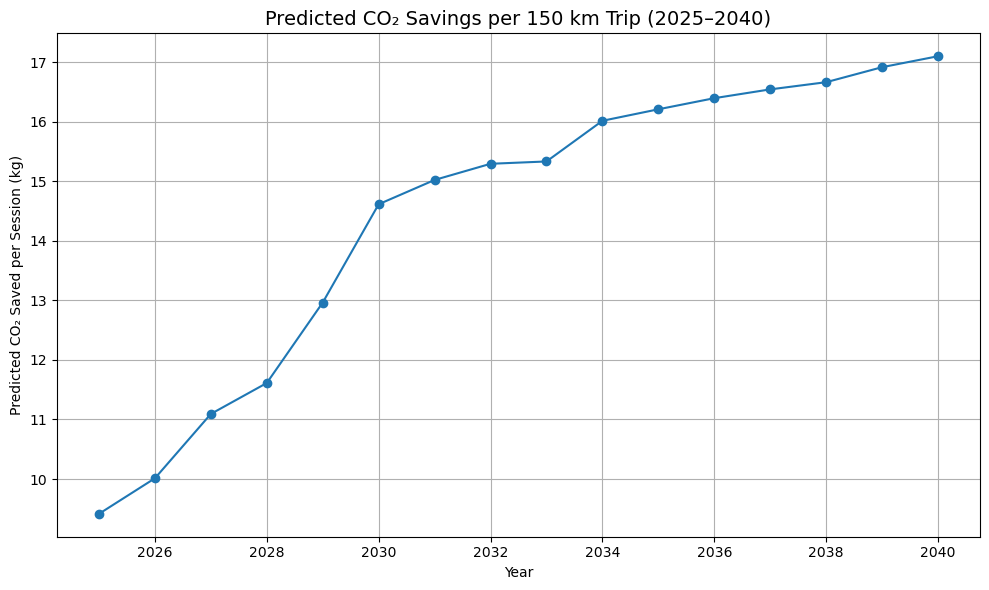

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(future_df['year'], future_df['predicted_CO2_saved_kg'], marker='o', linestyle='-')
plt.title("Predicted CO₂ Savings per 150 km Trip (2025–2040)", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Predicted CO₂ Saved per Session (kg)")
plt.grid(True)
plt.tight_layout()
plt.show()

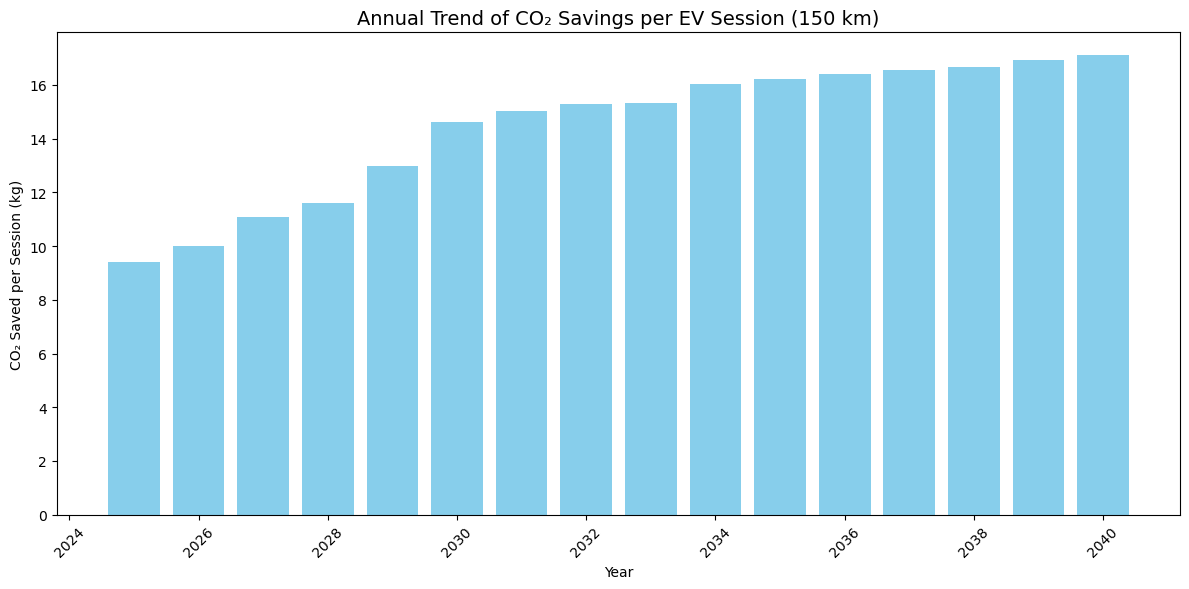

In [11]:
plt.figure(figsize=(12, 6))
plt.bar(future_df['year'], future_df['predicted_CO2_saved_kg'], color='skyblue')
plt.title("Annual Trend of CO₂ Savings per EV Session (150 km)", fontsize=14)
plt.xlabel("Year")
plt.ylabel("CO₂ Saved per Session (kg)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Insights from Future Per-Trip CO₂ Savings Predictions (2025–2040)

Based on the predictions generated using the Polynomial Ridge Regression model, we observe the following significant insights:

#### 1. Consistent Upward Trend
- Predicted CO₂ savings per 150 km EV trip increase steadily from **9.4 kg in 2025** to **17.1 kg in 2040**.
- This reflects the combined effect of increasing **EV adoption** and a **cleaner electricity grid** over time.

#### 2. Nonlinear Growth Pattern
- CO₂ savings grow at a faster rate between **2025 and 2030**, largely due to a sharp drop in the grid emission factor.
- After 2030, the growth rate slows slightly as the grid emission factor plateaus, showing diminishing returns from further decarbonization.

#### 3. Synergistic Impact
- From 2025 to 2040:
  - **EV adoption rate** grows from 12% to 56%
  - **Grid emission factor** drops from 0.61 to 0.13 kg CO₂/kWh
  - **Per-trip CO₂ savings nearly double**, showing the compounding benefits of clean transport and clean energy.

#### 4. Planning Implication
- This forecast highlights the importance of sustaining both **EV growth policies** and **grid decarbonization initiatives**.
- Even with a simplified model, the projections provide valuable **directional insight** for future environmental impact assessments and strategic planning.